Generate plots based on parametric dataset (compare 4 methods - two full signal and two trial-based):
* % of failed estimates (failed estimation and negative R-squared)
* ACF decline in specific range
* CI: 0 in the interval, width?
* R-squared (on unit level and as %)

Inclusion criteria:
* non zero bins
* 1 hz of activity
* R-squared > 0.5

In [1]:
import numpy as np
import pandas as pd
import pickle
import random

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\fig2_3_4a\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'

fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\inclusion\\'

In [3]:
save_fig = True

### Load data

In [4]:
tau_plot_all_long_df = pd.read_pickle(results_folder + 'tau_plot_long_durations_with_nans_df.pkl')
tau_plot_all_long_df.rename(columns={'decline_150_250': 'acf_decline'}, inplace=True)

tau_plot_all_long_df['ci_zero_excluded'] = (
    (tau_plot_all_long_df['tau_lower'] > 0) | (tau_plot_all_long_df['tau_upper'] < 0)
).astype(int)

In [5]:
tau_plot_all_long_df

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,duration_s,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_zero_excluded
0,0,1.566493,1.323501e+00,1.809484e+00,9.808670e-01,True,acf_full,78.324630,60,7.741821,0.851099,150.923515,72.598885,48.103097,1
1,1,1.784062,1.446069e+00,2.122055e+00,9.712531e-01,True,acf_full,89.203091,60,4.394396,0.858098,147.947233,58.744141,39.706144,1
2,2,11.235673,2.536052e+00,1.993529e+01,9.054904e-01,True,acf_full,561.783647,60,8.587393,0.528805,267.002290,294.781357,110.404056,1
3,3,2.591130,-4.099511e+00,9.281771e+00,1.567300e-01,False,acf_full,129.556491,60,6.976707,0.300692,194.403797,64.847306,33.357016,0
4,4,1.449421,4.827700e-01,2.416071e+00,7.381109e-01,True,acf_full,72.471033,60,0.950832,0.691458,239.986489,167.515455,69.802036,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,99995,1.986132,1.177967e+00,2.794297e+00,8.793473e-01,True,isttc_full,99.306590,600,2.672839,0.244627,125.243251,25.936660,20.709028,1
999996,99996,1.645728,1.509982e+00,1.781475e+00,9.944713e-01,True,isttc_full,82.286403,600,5.754497,0.596987,94.481295,12.194892,12.907203,1
999997,99997,2.906520,1.998661e+00,3.814378e+00,9.291005e-01,True,isttc_full,145.325980,600,5.604441,0.258915,174.189672,28.863692,16.570266,1
999998,99998,1.571276,8.281927e-01,2.314360e+00,8.464486e-01,True,isttc_full,78.563818,600,1.219057,0.187620,76.565797,1.998022,2.609549,1


In [6]:
tau_plot_all_long_df.keys()

Index(['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared',
       'acf_decline', 'method', 'tau_ms', 'duration_s', 'fr', 'alpha',
       'tau_ms_true', 'tau_diff_abs', 'tau_diff_rel', 'ci_zero_excluded'],
      dtype='object')

### Plot overlall stats (without within unit comparison)

In [7]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2'

colors = [color_acf_full, color_isttc_full]

#### % of failed estimates (failed estimation and negative R-squared)

In [8]:
def compute_exclusion(group):
    tau_nans = group['tau'].isna().sum()
    fit_r_squared_neg = (group['fit_r_squared'] < 0).sum()
    either_issue = ((group['tau'].isna()) | (group['fit_r_squared'] < 0)).sum()
    total = len(group)
    percent_tau_nans = 100 * tau_nans / total if total > 0 else 0
    percent_fit_r_squared_neg = 100 * fit_r_squared_neg / total if total > 0 else 0
    percent_either_issue = 100 * either_issue / total if total > 0 else 0
    return pd.Series({
        'tau_nans': tau_nans,
        'fit_r_squared_neg': fit_r_squared_neg,
        'exclusion': either_issue,
        'percent_tau_nans': percent_tau_nans,
        'percent_fit_r_squared_neg': percent_fit_r_squared_neg,
        'exclusion_perc': percent_either_issue
    })

exclusion_df = tau_plot_all_long_df.groupby(['method', 'duration_s']).apply(compute_exclusion).reset_index()
exclusion_df

C:\Users\ipochino\AppData\Local\Temp\ipykernel_5532\1431779627.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exclusion_df = tau_plot_all_long_df.groupby(['method', 'duration_s']).apply(compute_exclusion).reset_index()


,method,duration_s,tau_nans,fit_r_squared_neg,exclusion,percent_tau_nans,percent_fit_r_squared_neg,exclusion_perc
0,acf_full,60,383.0,3003.0,3386.0,0.383,3.003,3.386
1,acf_full,150,123.0,1326.0,1449.0,0.123,1.326,1.449
2,acf_full,300,34.0,659.0,693.0,0.034,0.659,0.693
3,acf_full,450,18.0,376.0,394.0,0.018,0.376,0.394
4,acf_full,600,11.0,237.0,248.0,0.011,0.237,0.248
5,isttc_full,60,0.0,3123.0,3123.0,0.000,3.123,3.123
6,isttc_full,150,0.0,1294.0,1294.0,0.000,1.294,1.294
7,isttc_full,300,0.0,669.0,669.0,0.000,0.669,0.669
8,isttc_full,450,0.0,361.0,361.0,0.000,0.361,0.361
9,isttc_full,600,0.0,238.0,238.0,0.000,0.238,0.238


In [9]:
def plot_one_threshold_jittered_lines(ax, df, field_to_plot, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        # ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        # ("sttc_trial_avg",     color_sttc_trail_avg,     "sttc_avg"),
        # ("sttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
        ("acf_full",           color_acf_full,           "acf_full"),
        ("isttc_full",         color_isttc_full,         "isttc_full"),
    ]

    # fixed ordering of intervals
    cats = list(df["duration_s"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["duration_s"]])
        y  = sub[field_to_plot].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

#### ACF decline and CI without zero

In [10]:
included_df = tau_plot_all_long_df.query('tau.notna() and fit_r_squared >= 0').copy()
print(f'len {len(included_df)}')
included_df.groupby(by='method', as_index=False).count()

len 988145


,method,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,tau_ms,duration_s,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_zero_excluded
0,acf_full,493830,493830,493830,493830,493830,493830,493830,493830,493830,493830,493830,493830,493830,493830
1,isttc_full,494315,494315,494315,494315,494315,494315,494315,494315,494315,494315,494315,494315,494315,494315


In [11]:
acf_decline_df = included_df.groupby(by=['method','duration_s']).agg(
    num_true=('acf_decline', lambda x: x.sum())
).assign(
    total=100000,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
acf_decline_df

,method,duration_s,num_true,total,percent_true
0,acf_full,60,68086,100000,68.086
1,acf_full,150,76878,100000,76.878
2,acf_full,300,82858,100000,82.858
3,acf_full,450,86059,100000,86.059
4,acf_full,600,88094,100000,88.094
5,isttc_full,60,69615,100000,69.615
6,isttc_full,150,78099,100000,78.099
7,isttc_full,300,83498,100000,83.498
8,isttc_full,450,86558,100000,86.558
9,isttc_full,600,88494,100000,88.494


In [12]:
ci_zero_df = included_df.groupby(by=['method','duration_s']).agg(
    num_true=('ci_zero_excluded', lambda x: x.sum())
).assign(
    total=100000,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
ci_zero_df

,method,duration_s,num_true,total,percent_true
0,acf_full,60,67239,100000,67.239
1,acf_full,150,79554,100000,79.554
2,acf_full,300,86892,100000,86.892
3,acf_full,450,90433,100000,90.433
4,acf_full,600,92695,100000,92.695
5,isttc_full,60,67263,100000,67.263
6,isttc_full,150,79383,100000,79.383
7,isttc_full,300,86619,100000,86.619
8,isttc_full,450,90179,100000,90.179
9,isttc_full,600,92500,100000,92.500


#### R-squared > 0.5

In [13]:
fit_r2_df = included_df.groupby(by=['method','duration_s']).agg(
    num_true=('fit_r_squared', lambda x: (x >= 0.5).sum())
).assign(
    total=100000,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
fit_r2_df

,method,duration_s,num_true,total,percent_true
0,acf_full,60,74692,100000,74.692
1,acf_full,150,85738,100000,85.738
2,acf_full,300,91949,100000,91.949
3,acf_full,450,94644,100000,94.644
4,acf_full,600,96294,100000,96.294
5,isttc_full,60,74578,100000,74.578
6,isttc_full,150,85397,100000,85.397
7,isttc_full,300,91703,100000,91.703
8,isttc_full,450,94497,100000,94.497
9,isttc_full,600,96128,100000,96.128


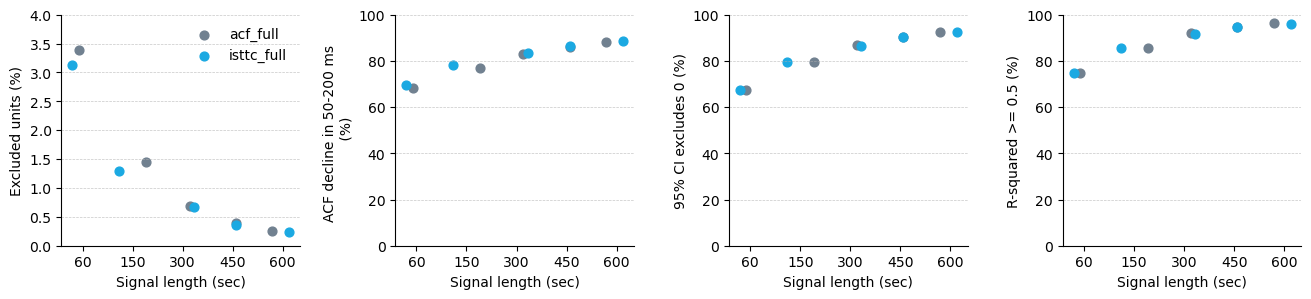

In [14]:
fig, axes = plt.subplots(1,4,figsize=(16,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold_jittered_lines(axes[0],
    exclusion_df, 'exclusion_perc',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[1],
    acf_decline_df, 'percent_true',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    ci_zero_df, 'percent_true',
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[3],
    fit_r2_df, 'percent_true',
    jitter=0.3, seed=42)

axes[0].set_ylabel('Excluded units (%)')
axes[1].set_ylabel('ACF decline in 50-200 ms \n (%)')
axes[2].set_ylabel('95% CI excludes 0 (%)')
axes[3].set_ylabel('R-squared >= 0.5 (%)')

axes[0].set_ylim([0, 4])
axes[1].set_ylim([0, 100])
axes[2].set_ylim([0, 100])
axes[3].set_ylim([0, 100])

for ax in axes.flat:
    ax.set_xlabel('Signal length (sec)')
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False)

if save_fig:
    plt.savefig(fig_folder + 'inclusion_durations.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'inclusion_durations.svg' , bbox_inches='tight')

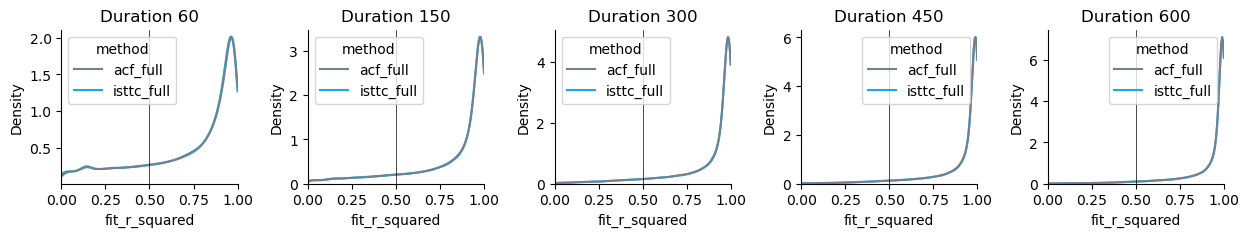

In [15]:
# R2 as KDE plots

fig, axes = plt.subplots(1,5, figsize=(15,2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

durations_s_l = list(included_df["duration_s"].unique())

for duration_idx, duration in enumerate(durations_s_l):
    sns.kdeplot(
        data=included_df.query('duration_s == @duration'), 
        x='fit_r_squared', 
        hue='method', 
        hue_order=['acf_full', 'isttc_full'],    
        clip=(0, 1),
        common_norm=True,  
        fill=False,
        palette=colors,
        legend=True,
        ax=axes[duration_idx]
    )
    axes[duration_idx].set_title(f'Duration {duration}')

for ax in axes.flat:
    ax.axvline(x=0.5, lw=0.5, c='k')
    ax.set_xlim([0,1])
    ax.set_xticks(np.linspace(0, 1, 5))

sns.despine()

save_fig=True

if save_fig:
    plt.savefig(fig_folder + 'r2_kde_plot_durations.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'r2_kde_plot_durations.svg' , bbox_inches='tight')